In [ ]:
# export
from typing import List
from fastai2.basics import *
from fastai2.text.all import *
from fastai2.vision.all import *
from pycocotools.coco import COCO

In [ ]:
# default_exp data_coco

# Data Coco
> 

In [ ]:
# exporti
train_img_path = Path('/root/data/coco/train2014')
train_anno_path = Path('/root/data/coco/annotations/captions_train2014.json')
val_img_path = Path('/root/data/coco/val2014')
val_anno_path = Path('/root/data/coco/annotations/captions_val2014.json')
tiny_img_path = Path('./tiny_data/tiny_imgs')
tiny_anno_path = Path('./tiny_data/captions_tiny.json')

In [ ]:
coco = COCO(tiny_anno_path)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## LM Datasets

In [ ]:
# exporti
def get_captions(coco):
    anns = coco.dataset['annotations']
    captions = [ann['caption'] for ann in anns]
    return captions

In [ ]:
captions = get_captions(coco)
captions[:3]

['A small closed toilet in a cramped space.',
 'A tan toilet and sink combination in a small room.',
 'This is an advanced toilet with a sink and control panel.']

In [ ]:
# exporti
def get_lm_dsets(captions, pct=1, valid_pct=0.2):
    captions = captions[:int(len(captions)*pct)]
    df = pd.DataFrame({'caption': captions})
    splits = RandomSplitter(seed=42, valid_pct=valid_pct)(df)
    tfms = [attrgetter('text'), Tokenizer.from_df('caption'), Numericalize()]
    dsets = Datasets(df, [tfms], splits=splits, dl_type=LMDataLoader)
    return dsets

In [ ]:
lm_dsets = get_lm_dsets(captions)
lm_dsets[0]

(TensorText([  2,   9,  30, 179,  19,  13,   9,   0, 230,  10]),)

In [ ]:
# export
def get_tiny_lm_dsets(pct=1, valid_pct=0.2):
    coco = COCO(tiny_anno_path)
    captions = get_captions(coco)
    lm_dsets = get_lm_dsets(captions, pct, valid_pct)
    return lm_dsets

def get_small_lm_dsets(pct=1, valid_pct=0.2):
    coco = COCO(val_anno_path)
    captions = get_captions(coco)
    lm_dsets = get_lm_dsets(captions, pct, valid_pct)
    return lm_dsets

In [ ]:
lm_dsets = get_tiny_lm_dsets()
lm_dls = lm_dsets.dataloaders(bs=16, seq_len=72)
lm_dls.show_batch(max_n=2)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


,text,text_
0,xxbos horses eating xxunk in a field with xxunk in the background xxbos a room under xxunk with an xxunk shower and xxunk for the sink . xxbos a row of parked cars sitting next to parking meters . xxbos xxmaj the bathroom is clean and ready to be xxunk . xxbos a woman cooking in a kitchen with xxunk counters . xxbos xxmaj people are xxunk on the street by a,horses eating xxunk in a field with xxunk in the background xxbos a room under xxunk with an xxunk shower and xxunk for the sink . xxbos a row of parked cars sitting next to parking meters . xxbos xxmaj the bathroom is clean and ready to be xxunk . xxbos a woman cooking in a kitchen with xxunk counters . xxbos xxmaj people are xxunk on the street by a homeless
1,to a sink xxbos a young kid with head xxunk on using a computer xxbos a man is sitting on the sidewalk while a police xxunk is doing xxunk behind xxunk . xxbos a toilet sitting in a bathroom next to a sink . xxbos a kitchen has all stainless steel appliances and counters . xxbos a young boy xxunk holding an umbrella xxunk the xxunk of a xxunk xxbos a white,a sink xxbos a young kid with head xxunk on using a computer xxbos a man is sitting on the sidewalk while a police xxunk is doing xxunk behind xxunk . xxbos a toilet sitting in a bathroom next to a sink . xxbos a kitchen has all stainless steel appliances and counters . xxbos a young boy xxunk holding an umbrella xxunk the xxunk of a xxunk xxbos a white toilet


## Generator Datasets

In [ ]:
# exporti
def get_captions_by_imgid(coco, img_id: int):
    return [ann['caption'] for ann in coco.imgToAnns[img_id]]
def get_imgfilepath_by_imgid(coco, img_id: int, img_path: Path):
    return img_path/coco.imgs[img_id]['file_name']
def imgpath_to_captions(coco, img_path: Path):
    img_ids = coco.getImgIds()
    return [ 
        [get_imgfilepath_by_imgid(coco, img_id, img_path), get_captions_by_imgid(coco, img_id)]
         for img_id in img_ids
    ]

In [ ]:
imgpath_to_captions(coco, tiny_img_path)[:2]

[[Path('tiny_data/tiny_imgs/COCO_val2014_000000391895.jpg'),
  ['A man with a red helmet on a small moped on a dirt road. ',
   'Man riding a motor bike on a dirt road on the countryside.',
   'A man riding on the back of a motorcycle.',
   'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. ',
   'A man in a red shirt and a red hat is on a motorcycle on a hill side.']],
 [Path('tiny_data/tiny_imgs/COCO_val2014_000000522418.jpg'),
  ['A woman wearing a net on her head cutting a cake. ',
   'A woman cutting a large white sheet cake.',
   'A woman wearing a hair net cutting a large sheet cake.',
   'there is a woman that is cutting a white cake',
   "A woman marking a cake with the back of a chef's knife. "]]]

In [ ]:
# export
def get_tiny_gen_dsets(vocab: List, pct=1, valid_pct=0.2):
    coco = COCO(tiny_anno_path)
    items = imgpath_to_captions(coco, tiny_img_path)
    items = items[:int(len(items)*pct)]
    splits = RandomSplitter(seed=42, valid_pct=valid_pct)(items)
    tfms = [
        [lambda item: item[1], lambda captions: random.choice(captions), Tokenizer(SpacyTokenizer()), Numericalize(vocab=vocab)], 
        [lambda item: item[0], PILImage.create]
    ]
    dsets = Datasets(items, tfms=tfms, splits=splits)
    return dsets

def get_small_gen_dsets(vocab: List, pct=1, valid_pct=0.2):
    coco = COCO(val_anno_path)
    items = imgpath_to_captions(coco, val_img_path)
    items = items[:int(len(items)*pct)]
    splits = RandomSplitter(seed=42, valid_pct=valid_pct)(items)
    tfms = [
        [lambda item: item[1], lambda captions: random.choice(captions), Tokenizer(SpacyTokenizer()), Numericalize(vocab=vocab)], 
        [lambda item: item[0], PILImage.create]
    ]
    dsets = Datasets(items, tfms=tfms, splits=splits)
    return dsets

In [ ]:
gen_dsets = get_tiny_gen_dsets(lm_dsets.vocab)
len(gen_dsets), gen_dsets[0]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


(100,
 (TensorText([  2,   9,  23,  37,  17,  15, 101,  14,   9,  66,  10]),
  PILImage mode=RGB size=640x360))

In [ ]:
# export
def get_gen_dls(dsets, bs, size):
    pad_idx = dsets.o2i['xxpad']
    dls = dsets.dataloaders(
        bs=bs, 
        before_batch=[partial(pad_input, pad_idx=pad_idx)],
        after_item=[ToTensor, Resize(size)],
        after_batch=[IntToFloatTensor(), Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5]))]
    )
    return dls

In [ ]:
gen_dls = get_gen_dls(gen_dsets, 16, 64)
for x, y in gen_dls.train:
    print(x.shape, x.dtype)
    print(y.shape, y.dtype)
    break

torch.Size([16, 19]) torch.int64
torch.Size([16, 3, 64, 64]) torch.float32


In [ ]:
# exporti
def displayable_caption(caption):
    new_cap = []
    for i, w in enumerate(caption.split()):
        i+=1
        if i>11: break
        new_cap.append(w)
        if i%6==0: new_cap.append('\n') 
    return ' '.join(new_cap)

In [ ]:
# export
@typedispatch
def show_batch(x: TensorText, y: TensorImage, samples, ctxs=None, max_n=10, **kwargs):
    n = min(len(samples), max_n)
    ncols = 4
    nrows = math.ceil(n/ncols)
    figsize = (ncols*4, nrows*4) 
    if ctxs is None: 
        _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        ctxs = ax.flatten()
    for i in range(n):
        caption, img = samples[i]
        img.show(ctxs[i])
        ctxs[i].text(0, -1.5, displayable_caption(caption))

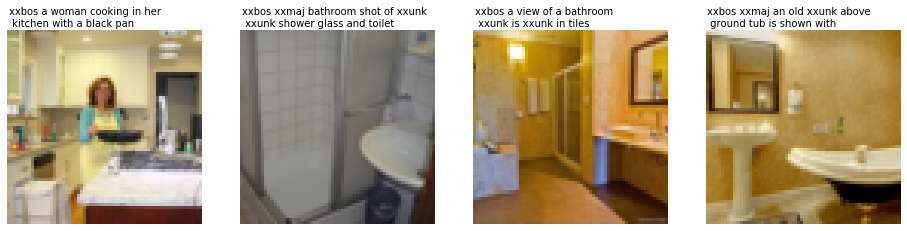

In [ ]:
gen_dls.show_batch(max_n=4)

## export -

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_eda[script].ipynb.
Converted 01_gen_coco_tiny_data[script].ipynb.
Converted 02_data_coco.ipynb.
Converted 03_model.ipynb.
Converted 04_loss.ipynb.
Converted 05_leaner.ipynb.
Converted 90a_fulltest_train_lm.ipynb.
Converted 90b_fulltest_train_generator.ipynb.
Converted 95a_train_lm[script].ipynb.
Converted 95b_train_generator[script].ipynb.
Converted 95c_train_gan.ipynb.
Converted index.ipynb.
